In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
price = pickle.load(open('price_data.pkl', 'rb'))

In [3]:
price_no_dai = price.drop('DAI', axis=1)
price_no_dai = price_no_dai.dropna()

price = price.dropna()
price_no_dai = price_no_dai.dropna()

In [4]:
price = price.resample('24h').mean()
price_no_dai = price_no_dai.resample('24h').mean()

In [5]:
returns = price.pct_change()
returns_no_dai = price_no_dai.pct_change()

In [6]:
returns = returns.dropna()
returns_no_dai = returns_no_dai.dropna()

# Correlation

In [7]:
def plot_correlation(returns, normed=True, std=False):
    """ Heatmap of return correlations.
    
        :param returns: Daily returns, i.e. daily_prices_df.pct_change()
    """
    mean_returns = returns.mean()
    vmin = None
    vmax = None
    if normed:
        cov = returns.corr()
        vmin = -1
        vmax = 1
    elif std:
        cov = np.sqrt(returns.cov())
    else:
        cov = returns.cov()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov, cmap='RdBu', annot=True, vmin=vmin, vmax=vmax);

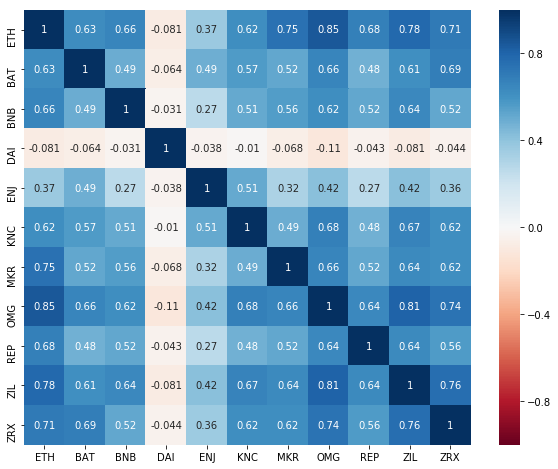

In [8]:
plot_correlation(returns)

In [9]:
# plot_correlation(returns_no_dai)

# Markowitz

In [10]:
def compute_markowitz(returns, n_portfolios=10000):
    results = np.zeros((4 + len(returns.columns) - 1, n_portfolios))
    mean_returns = returns.mean()
    cov = returns.cov()

    for i in range(n_portfolios):
        # random portfolio weights
        weights = np.random.random(len(returns.columns))
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

        # store results in results array
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        # store Sharpe Ratio (return / volatility)
        results[2, i] = results[0, i] / results[1, i]
        for j in range(len(weights)):
            results[j+3,i] = weights[j]

    # convert results array to DataFrame
    results_df = pd.DataFrame(
        results.T, columns=['return', 'volatility', 'sharpe'] + returns.columns.tolist())

    # portfolio with highest Sharpe Ratio
    max_sharpe_port = results_df.iloc[results_df['sharpe'].idxmax()]
    # portfolio with minimum standard deviation (that yields positive returns)
    pos = results_df[results_df['return'] > 0]
    m = pos[pos['volatility'] == pos['volatility'].min()]
    min_vol_port = results_df[results_df.values == m.values].iloc[0]
    # min_vol_port = results_df.iloc[results_df['volatility'].idxmin()]
    
    return results_df, max_sharpe_port, min_vol_port

In [28]:
def plot_markowitz(results_df, max_sharpe_port=None, min_vol_port=None):
    # create scatter plot coloured by Sharpe Ratio
    plt.figure(figsize=(15, 10))
    plt.scatter(results_df['volatility'], results_df['return'], c=results_df['sharpe'],
               cmap='Purples', label='')
    plt.colorbar()
    plt.xlabel('risk', fontsize=18)
    plt.ylabel('returns', fontsize=18)
    
    if max_sharpe_port is not None:
        plt.scatter(max_sharpe_port[1], max_sharpe_port[0], facecolor='m',
                    marker='*', s=200, label='max sharpe portfolio'.format(max_sharpe_port[0] * 100))
    if min_vol_port is not None:
        plt.scatter(min_vol_port[1], min_vol_port[0], facecolor='tab:orange',
                    marker='*', s=200, label='min volatility portfolio'.format(min_vol_port[0] * 100));
    plt.grid(True, 'both', alpha=0.4)
    plt.legend(fontsize=18)

In [32]:
def plot_portfolios(max_share_port, min_vol_port):
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    weights = max_sharpe_port[3:].sort_values(ascending=False)
    plt.bar(np.arange(len(weights)), weights, facecolor='tab:purple')
    plt.gca().set_xticks(np.arange(len(weights)))
    plt.gca().set_xticklabels(weights.index, rotation=70, fontsize=14)
    plt.title('max sharpe ratio portfolio | daily return: {:.3} %'.format(
        max_sharpe_port[0] * 100), fontsize=16)
    plt.grid(True, 'both', alpha=0.4)


    plt.subplot(122)
    weights = min_vol_port[3:].sort_values(ascending=False)
    plt.bar(np.arange(len(weights)), weights, facecolor='tab:purple')
    plt.gca().set_xticks(np.arange(len(weights)))
    plt.gca().set_xticklabels(weights.index.tolist(), rotation=70, fontsize=14)
    plt.title('min volatility portfolio | daily return: {:.3} %'.format(
        min_vol_port[0] * 100), fontsize=16);
    plt.grid(True, 'both', alpha=0.4)

# Simulations


In [35]:
N = 50000

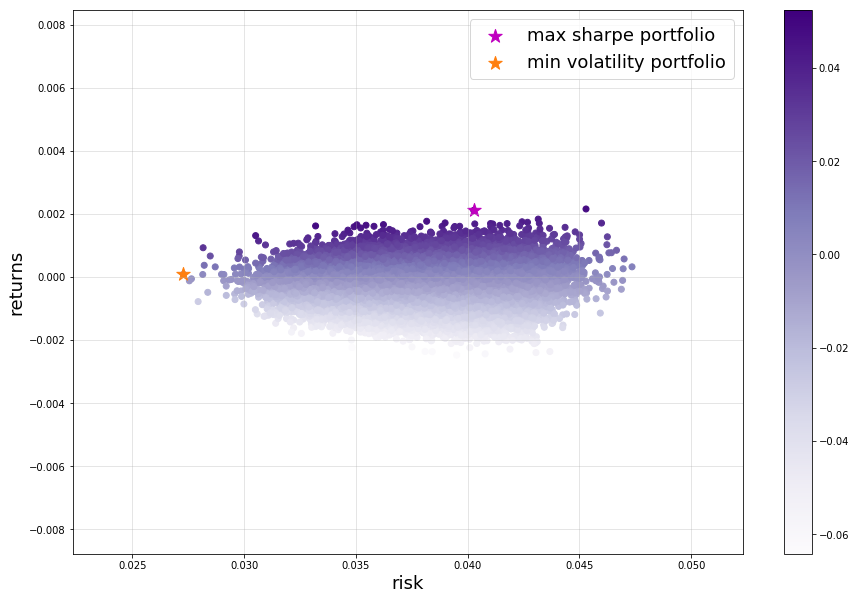

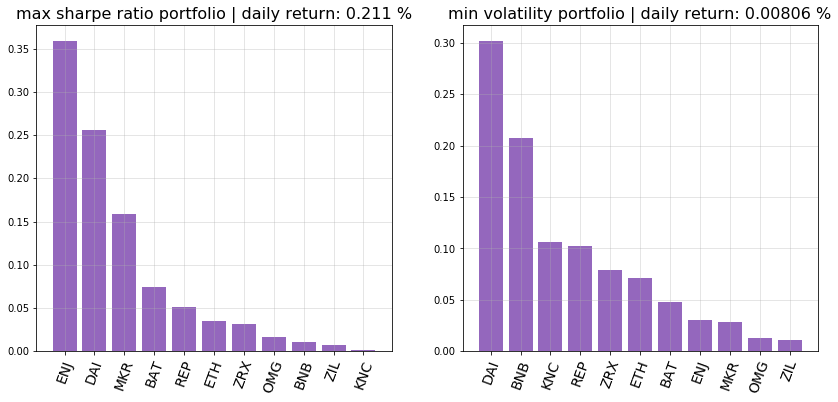

In [36]:
results_df, max_sharpe_port, min_vol_port = compute_markowitz(returns, N)
plot_markowitz(results_df, max_sharpe_port, min_vol_port)
plot_portfolios(max_sharpe_port, min_vol_port)

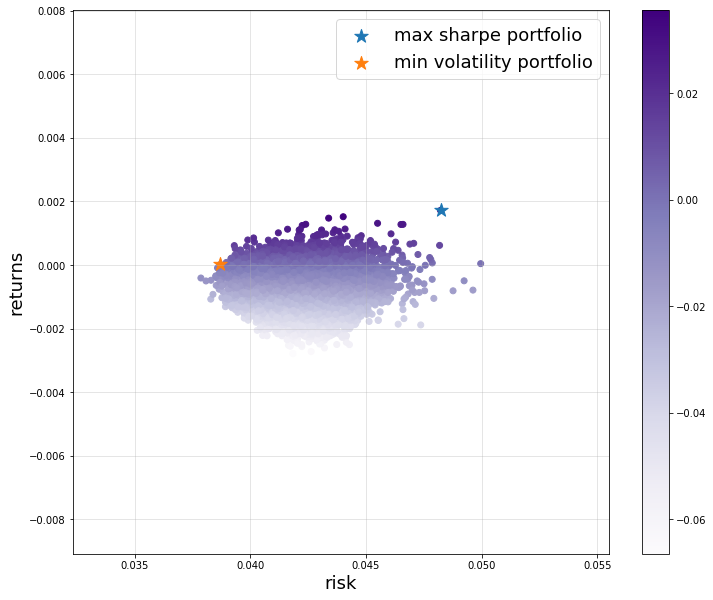

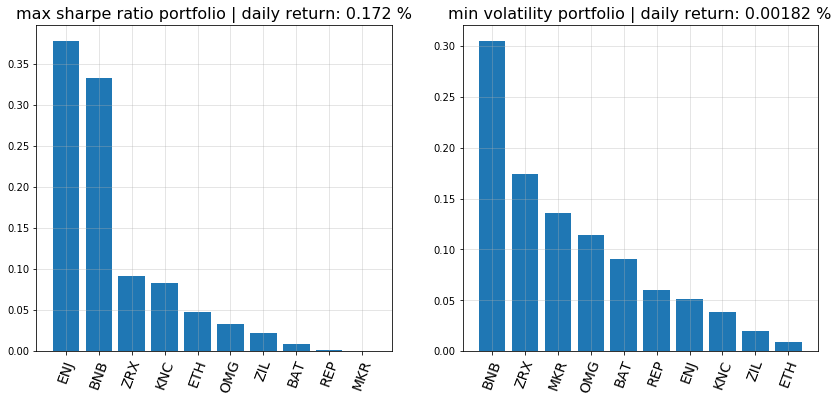

In [15]:
results_df, max_sharpe_port, min_vol_port = compute_markowitz(returns_no_dai, N)
plot_markowitz(results_df, max_sharpe_port, min_vol_port)
plot_portfolios(max_sharpe_port, min_vol_port)